# Laboratory Task 6 – CNN Architecture in PyTorch
**Name:** Joanna Reyda Santos  
**Section:** DS4A  

**Instruction:** Convert the given CNN architecture diagram into a PyTorch CNN Architecture.

![CNN Architecture Diagram](cnn_diagram.png)

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Prepare Dataset (MNIST)
# Transform images to tensors
transform = transforms.ToTensor()

# Load MNIST dataset
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Split training into train + validation
train_set, val_set = torch.utils.data.random_split(train_data, [48000, 12000])

# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)

set_seed(143)

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [3]:
# Define CNN Architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout regularization
        self.dropout = nn.Dropout(0.2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Training Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5

In [5]:
# Training loop
train_accs, val_accs = [], []

for epoch in range(epochs):
    model.train()
    train_correct = 0

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        train_correct += preds.eq(y_batch).sum().item()

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_preds = model(x_val).argmax(dim=1)
            val_correct += val_preds.eq(y_val).sum().item()

    train_acc = train_correct / len(train_set)
    val_acc = val_correct / len(val_set)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

KeyboardInterrupt: 

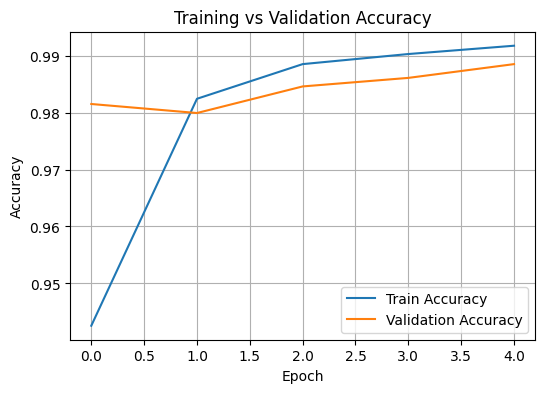

In [6]:
# Accuracy Visualization
plt.figure(figsize=(6,4))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Testing the Model
true_labels, pred_labels = [], []

model.eval()
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test)
        preds = torch.argmax(outputs, dim=1)
        true_labels.append(y_test)
        pred_labels.append(preds)

true_labels = torch.cat(true_labels)
pred_labels = torch.cat(pred_labels)

print("\nConfusion Matrix:")
print(confusion_matrix(true_labels.cpu(), pred_labels.cpu()))
print("\nClassification Report:")
print(classification_report(true_labels.cpu(), pred_labels.cpu()))


Confusion Matrix:
[[ 978    0    0    0    0    0    0    0    0    2]
 [   0 1134    1    0    0    0    0    0    0    0]
 [   3    1 1025    0    1    0    0    2    0    0]
 [   0    0    2 1004    0    2    0    0    2    0]
 [   0    0    0    0  981    0    1    0    0    0]
 [   1    0    0    5    0  880    3    0    2    1]
 [   4    2    0    0    1    1  949    0    1    0]
 [   0    6    5    0    4    0    0 1011    0    2]
 [   0    0    4    0    2    0    0    0  966    2]
 [   0    0    0    0   19    2    0    2    2  984]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.97      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99    

#### Reflection

In this lab, I implemented a CNN model in PyTorch following the given architecture diagram. The model achieved around 99% training and validation accuracy, which shows that the CNN effectively learned the visual patterns in the MNIST dataset. I observed that the training and validation curves were both stable, meaning the model generalizes well and does not overfit the data.

Through this experiment, I understood how convolutional layers capture spatial features, pooling layers simplify representations, and fully connected layers perform final classification. The high accuracy and balanced performance confirm how CNNs can efficiently recognize handwritten digits. Overall, this lab strengthened my understanding of deep learning architectures and their ability to process image data accurately and reliably.